# Modelo de classificação kNN
Neste arquivo será criado um modelo kNN e serão otimizados seus hiperparâmetros para fazer previsões do estado de saúde dos pacientes a partir de seus biomarcadores. O dataframe escolhido para este estudo tem uma coluna denominada Class, que guarda o estado do indivíduo, entre Control e Impaired. Os indivíduos classificados como Control são indivíduos de controle saudáveis, enquanto Impaired são indivíduos afetados por Alzheimer.

A métrica usada para selecionar os atributos e otimizar os hiperparâmetros do modelo será a f1-score. Considerando que nosso modelo é planejado para ser usado num contexto de saúde, devemos ser bastante rigorosos com a qualidade do modelo, estabelecendo um f1-score mínimo aceitável de 0.8.

In [26]:
# Bibliotecas
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from optuna import create_study
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

## Importando dados:
Aqui os dados serão importados e devidamente manipulados. Como consequência da exportação dos arquivos csv feita pelo código do tratamento geral, surge uma coluna que carrega os índices de cada fileira. Como não queremos que esta interfira em qualquer procedimento de nosso modelo, vamos excluí-la. 

Como nosso target é categórico binário, devemos codificá-lo em 0 e 1 para que nosso modelo funcione. O valor 'Control' será codificado como 0 e o valor 'Impaired' será codificado como 1.

In [27]:
# Importando dados
features = pd.read_csv("Features para treino.csv")
features = features.drop("Unnamed: 0", axis=1)

target = pd.read_csv("Target para treino.csv")
target = target["Class"]
X_treino = features.values

X_teste = pd.read_csv("Features para teste.csv")
X_teste = X_teste.drop("Unnamed: 0", axis=1).values
y_teste = pd.read_csv("Target para teste.csv")["Class"]

In [28]:
#Normalizando o target:
le = LabelEncoder()
nle = LabelEncoder()
target = le.fit_transform(target)
y_teste = nle.fit_transform(y_teste)

## Seleção de atributos:
Nesta parte do código, executaremos a seleção de atributos de nossas features. Utilizaremos o algoritmo de Seleção Sequencial de Atributos, que calcula a importância de cada coluna para o resultado do modelo e retira as colunas que não são interessantes para análise. 

In [29]:
# Selecionando features
from sklearn.feature_selection import SequentialFeatureSelector

modelo = KNeighborsClassifier()
seletor = SequentialFeatureSelector(
    modelo,
    n_features_to_select="auto",
    direction="backward",
    scoring="f1",
    cv = 5,
    n_jobs=-1
)

seletor.fit(features, target)

X_treino = seletor.transform(features)
X_teste = seletor.transform(X_teste)

print(f"Número original de atributos: {seletor.n_features_in_}")
print(f"Número de atributos selecionados: {seletor.n_features_to_select_}")
print(f"Colunas selecionadas: {seletor.support_}")

Número original de atributos: 134
Número de atributos selecionados: 67
Colunas selecionadas: [False False False False False False False  True False False False False
 False  True False False False  True False False False False  True  True
 False False False  True False False  True False False False False False
 False False False  True False False  True False  True False False False
 False False  True  True False False  True False False False  True  True
 False False  True  True  True False  True False False  True False False
  True False  True False  True False  True  True  True False  True  True
  True False  True False False False  True False  True  True False False
 False False False  True  True  True  True  True  True  True False  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True]


C:\Users\vitor25023\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SequentialFeatureSelector was fitted with feature names
  warnings.warn(


## Otimização de hiperparâmetros:
Nesta parte do código, otimizamos os hiperparâmetros do modelo k-NN Classifier padrão do Sci-Kit Learn utilizando o Optuna, que permite uma otimização inteligente dos hiperparâmetros do modelo. Para isso, foram criadas as funções de instância, objetivo e objetivo parcial a fim de que sejam utilizadas no estudo do optuna. A fim de garantir que o melhor conjunto de hiperparâmetros foi utilizado, foram feitos 1000 trials com diferentes conjuntos de hiperparâmetros, o que se mostrou um valor exagerado no final.

Vamos otimizar os seguintes hiperparâmetros: quantidade de vizinhos, se a distância dos vizinhos será considerada ao calcular o resultado (peso), e tipo de distância (Manhattan ou Euclidiana).

In [30]:
# Preparando a otimização de hiperparâmetros com optuna
#Criando as funções auxiliares
def instancia_geral(trial, parametros, algoritmo):
    modelo = algoritmo(**parametros)
    return modelo

def objetivo_geral(trial, parametros, algoritmo):
    modelo = instancia_geral(trial, parametros, algoritmo)
    metricas = cross_val_score(
        modelo,
        features,
        target,
        scoring="f1",
        cv= 5
    )
    return metricas.mean()


def funcao_objetivo_parcial_knn(trial):
    parametros = {"n_neighbors": trial.suggest_int("n_neighbors", 2, 100),
                  "weights": trial.suggest_categorical("weights", ["uniform", "distance"]),
                  "p": trial.suggest_int("p", 1, 2)}
    return objetivo_geral(trial, parametros, KNeighborsClassifier)

In [31]:
NOME_DO_ESTUDO = "knn3"
estudo_knn = create_study(
    direction="maximize",
    study_name=NOME_DO_ESTUDO,
    storage=f"sqlite:///{NOME_DO_ESTUDO}.db",
    load_if_exists=True,
)

estudo_knn.optimize(funcao_objetivo_parcial_knn, n_trials=1000)

[I 2025-11-03 21:01:19,501] A new study created in RDB with name: knn3
[I 2025-11-03 21:01:19,688] Trial 0 finished with value: 0.0 and parameters: {'n_neighbors': 47, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 0.0.
[I 2025-11-03 21:01:19,864] Trial 1 finished with value: 0.0 and parameters: {'n_neighbors': 59, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 0.0.
[I 2025-11-03 21:01:20,042] Trial 2 finished with value: 0.0 and parameters: {'n_neighbors': 84, 'weights': 'distance', 'p': 1}. Best is trial 0 with value: 0.0.
[I 2025-11-03 21:01:20,227] Trial 3 finished with value: 0.0 and parameters: {'n_neighbors': 78, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 0.0.
[I 2025-11-03 21:01:20,405] Trial 4 finished with value: 0.0 and parameters: {'n_neighbors': 48, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 0.0.
[I 2025-11-03 21:01:20,604] Trial 5 finished with value: 0.0 and parameters: {'n_neighbors': 56, 'weights': 'distance', 'p

## Execução e validação cruzada do modelo: 
Aqui, será instanciado um modelo k-NN Classifier com os hiperparâmetros selecionados pelo Optuna. O modelo será treinado com os conjuntos de dados de treino e em seguida, será testado com os dados de teste. 

Primeiro, será calculada a acurácia do modelo, em seguida, será feita uma validação cruzada para estimar a sensitividade do modelo.

In [36]:
# Treinando um modelo k-NN com estes parâmetros
params = estudo_knn.best_trial.params

predictor = KNeighborsClassifier(**params)
predictor.fit(X_treino, target)
print(params)

{'n_neighbors': 5, 'weights': 'uniform', 'p': 1}


In [37]:
y_pred = predictor.predict(X_teste)
accuracy = accuracy_score(y_teste, y_pred)
print(accuracy)

y_pred_trans = le.inverse_transform(y_pred)

medida = cross_val_score(predictor, X_teste, y_teste, scoring="f1", cv=5)
print("F1-score médio no conjunto de teste:", medida.mean())

medida = cross_val_score(predictor, X_teste, y_teste, scoring="accuracy", cv=5)
print("Acurácia média no conjunto de teste:", medida.mean())

0.6428571428571429
F1-score médio no conjunto de teste: 0.1
Acurácia média no conjunto de teste: 0.6551470588235294


## Resultados e discussão:

['Control' 'Impaired']


<Axes: >

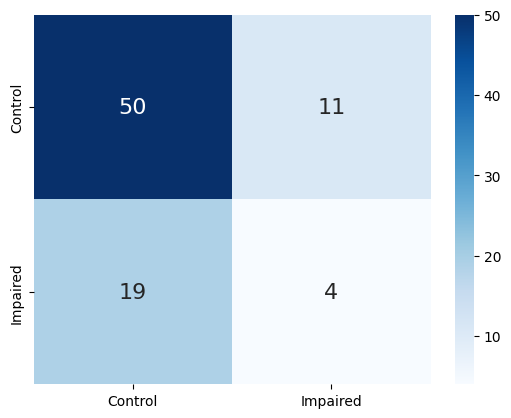

In [38]:
#Montando a matriz de confusão 
classes = np.unique(y_pred_trans)
Y = nle.inverse_transform(y_teste)
print(classes)
cm = confusion_matrix(Y, y_pred_trans, labels=classes)
df_conf = pd.DataFrame(cm, classes, classes)
sns.heatmap(df_conf, annot=True, annot_kws={"size": 16}, cmap="Blues")

In [35]:
print(classification_report(Y, y_pred_trans))

              precision    recall  f1-score   support

     Control       0.72      0.82      0.77        61
    Impaired       0.27      0.17      0.21        23

    accuracy                           0.64        84
   macro avg       0.50      0.50      0.49        84
weighted avg       0.60      0.64      0.62        84



Conforme vemos o heatmap e o classification_report acima, temos em mãos um modelo muito fraco para nossos propósitos. O valor da F1-score dos indivíduos classificados como Impaired é de 0.21, possuindo precisão e recall muito baixos. O modelo apresenta erro tipo 2 muito forte, há mais falsos positivos do que verdadeiros positivos no modelo.

A análise da validação cruzada, a f1-score do modelo é ainda mais baixa: 0.1, evidenciando que o modelo tem pouquíssima precisão e recall. Muito provavelmente, isso é observado devido o grande desbalanço de dados do modelo, há muito mais indivíduos de controle do que afetados no dataset de teste, o que prejudica muito o desempenho do modelo. Além disso, o modelo também tem uma acurácia média da validação cruzada de 0.65, o que podemos considerar baixo. 


## Referências: 
